In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [2]:
def sample_noise(m, n):
    return np.random.uniform(-1, 1, size = [m, n])

In [3]:
class Model:
    
    def __init__(self, learning_rate):
        
        self.X = tf.placeholder(tf.float32, shape = [None, 784])
        
        self.discriminator_W = tf.Variable(tf.random_normal([784, 128], stddev = 0.1))
        self.discriminator_b = tf.Variable(tf.zeros([128]))
        self.discriminator_W_out = tf.Variable(tf.random_normal([128, 1], stddev = 0.1))
        self.discriminator_b_out = tf.Variable(tf.zeros([1]))
        
        backpropagate_discriminator = [self.discriminator_W, self.discriminator_b, self.discriminator_W_out, self.discriminator_b_out]
        
        self.Z = tf.placeholder(tf.float32, shape = [None, 100])
        
        self.generator_W = tf.Variable(tf.random_normal([100, 128], stddev = 0.1))
        self.generator_b = tf.Variable(tf.zeros([128]))
        self.generator_W_out = tf.Variable(tf.random_normal([128, 784], stddev = 0.1))
        self.generator_b_out = tf.Variable(tf.zeros([784]))
        
        backpropagate_generator = [self.generator_W, self.generator_W_out, self.generator_b, self.generator_b_out]
        
        def discriminator(z):
            
            discriminator_hidden1 = tf.nn.relu(tf.matmul(z, self.discriminator_W) + self.discriminator_b)
            discriminator_out = tf.matmul(discriminator_hidden1, self.discriminator_W_out) + self.discriminator_b_out
            
            return discriminator_out
        
        def generator(z):
            
            generator_hidden1 = tf.nn.relu(tf.matmul(z, self.generator_W) + self.generator_b)
            generator_out = tf.matmul(generator_hidden1, self.generator_W_out) + self.generator_b_out
            
            return tf.nn.sigmoid(generator_out)
        
        self.generator_sample = generator(self.Z)
        discriminator_real = discriminator(self.X)
        discriminator_fake = discriminator(self.generator_sample)
        
        discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_real, labels = tf.ones_like(discriminator_real)))
        discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_fake, labels = tf.zeros_like(discriminator_fake)))
        
        self.discriminator_total_loss = discriminator_loss_real + discriminator_loss_fake
        
        self.generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = discriminator_fake, labels = tf.ones_like(discriminator_fake)))
        
        self.optimizer_discriminator = tf.train.AdamOptimizer(learning_rate).minimize(self.discriminator_total_loss, var_list = backpropagate_discriminator)
        self.optimizer_generator = tf.train.AdamOptimizer(learning_rate).minimize(self.generator_loss, var_list = backpropagate_generator)

In [4]:
sample_size_output = 16
sample_size_train = 128
learning_rate = 0.001

epoch = 30000

mnist = input_data.read_data_sets('/home/huseinzol05/Documents/MNIST/MNIST_data')

Extracting /home/huseinzol05/Documents/MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/huseinzol05/Documents/MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/huseinzol05/Documents/MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/huseinzol05/Documents/MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


epoch: 5000, discriminator loss: 0.202308, generator loss: 5.07559, s / 5k epoch: 0.00780701637268


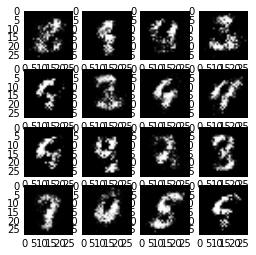

epoch: 10000, discriminator loss: 0.334415, generator loss: 3.26136, s / 5k epoch: 0.00814509391785


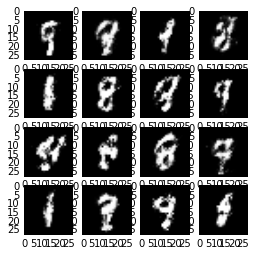

epoch: 15000, discriminator loss: 0.440273, generator loss: 2.63892, s / 5k epoch: 0.00771498680115


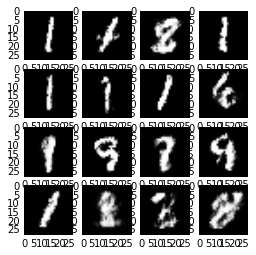

epoch: 20000, discriminator loss: 0.698306, generator loss: 2.40815, s / 5k epoch: 0.0120577812195


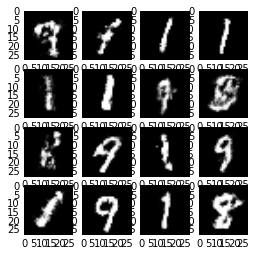

epoch: 25000, discriminator loss: 0.45355, generator loss: 2.97181, s / 5k epoch: 0.00917911529541


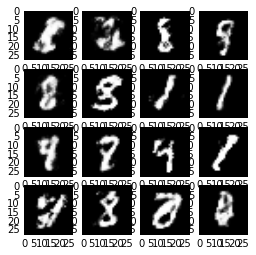

epoch: 30000, discriminator loss: 0.575854, generator loss: 2.64354, s / 5k epoch: 0.00875091552734


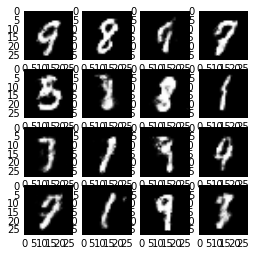

In [5]:
EPOCH = []; DISCRIMINATOR_LOSS = []; GENERATOR_LOSS = []
sess = tf.InteractiveSession()
model = Model(learning_rate)
sess.run(tf.global_variables_initializer())

for i in xrange(epoch):
    EPOCH.append(i)
    last_time = time.time()
    input_images, _ = mnist.train.next_batch(sample_size_train)
    _, discriminator_loss = sess.run([model.optimizer_discriminator, model.discriminator_total_loss], feed_dict = {model.X : input_images, model.Z : sample_noise(sample_size_train, 100)})
    _, generator_loss = sess.run([model.optimizer_generator, model.generator_loss], feed_dict = {model.Z : sample_noise(sample_size_train, 100)})
    DISCRIMINATOR_LOSS.append(discriminator_loss); GENERATOR_LOSS.append(generator_loss)
    
    if (i + 1) % 5000 == 0:
        print "epoch: " + str(i + 1) + ", discriminator loss: " + str(discriminator_loss) + ", generator loss: " + str(generator_loss) + ", s / 5k epoch: " + str(time.time() - last_time)
        
        fig = plt.figure(figsize = (4, 4))
        
        samples = sess.run(model.generator_sample, feed_dict = {model.Z: sample_noise(sample_size_output, 100)})
        
        for z in xrange(sample_size_output):
            
            plt.subplot(sample_size_output / 4, 4, z + 1)
            plt.imshow(samples[z].reshape(28, 28), cmap = 'Greys_r')
            
        plt.show()

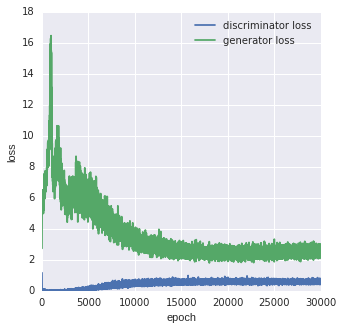

In [8]:
import seaborn as sns
sns.set()
fig = plt.figure(figsize = (5, 5))
plt.plot(EPOCH, DISCRIMINATOR_LOSS, label = 'discriminator loss')
plt.plot(EPOCH, GENERATOR_LOSS, label = 'generator loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()